In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
import folium
from pyspark.sql import SparkSession, Window, functions as F
from pyspark.sql.functions import countDistinct, col, date_format
import numpy as np
import pyspark.sql.functions as func
from pyspark.sql.types import (
    StringType,
    LongType,
    DoubleType,
    StructField,
    StructType,
    FloatType
)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Start Spark Session
spark = (
    SparkSession.builder.appName("MAST30034 Project 2 BNPL")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

22/09/21 19:57:02 WARN Utils: Your hostname, LAPTOP-URHBN55Q resolves to a loopback address: 127.0.1.1; using 10.13.192.107 instead (on interface wifi0)
22/09/21 19:57:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/21 19:57:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# load all transactions datasets
paths=['../data/tables/transactions_20210228_20210827_snapshot',
       '../data/tables/transactions_20210828_20220227_snapshot',
       '../data/tables/transactions_20220228_20220828_snapshot']

first = 1
for path in paths:
    if first:
        transactions = spark.read.parquet(path)
        print(f'added {path.split("/")[3]}')
        first = 0
    else:
        append_transactions = spark.read.parquet(path)
        transactions = transactions.union(append_transactions)
        print(f'added {path.split("/")[3]}')

added transactions_20210228_20210827_snapshot
added transactions_20210828_20220227_snapshot


added transactions_20220228_20220828_snapshot


In [4]:
consumer = spark.read.csv("../data/tables/tbl_consumer.csv", header=True, sep="|")
details = spark.read.parquet("../data/tables/consumer_user_details.parquet")
merchants = spark.read.parquet("../data/tables/tbl_merchants.parquet")

In [5]:
# rename columns
merchants = merchants.withColumnRenamed('name', 'merchant_name')
consumer = consumer.withColumnRenamed('name', 'consumer_name')

In [6]:
# Join consumers with their respective details
consumer_detail = consumer.join(details, on="consumer_id")

# Join consumers with their respective transactions
consumer_trx = consumer_detail.join(transactions, on="user_id")

# Join transactions with the respective merchants
df_trx = consumer_trx.join(merchants, on="merchant_abn")

In [7]:
from pyspark.sql.types import *
@F.udf(StringType())
def normalize_tags(col):
    return col.replace("(", "[").replace(")", "]")[1:-1]

@F.udf(StringType())
def clean_string(col):
    col = col.lower()
    return " ".join(col.split())

In [8]:
df_trx = df_trx.withColumn("tags", normalize_tags(F.col("tags")))
df_trx = df_trx.withColumn("categories", F.regexp_extract("tags", "(?<=\[)(.*?)(?=\])", 1))
df_trx = df_trx.withColumn("revenue_level", F.regexp_extract("tags", "(?<=,\s\[)([a-e]+?)(?=\],)", 1))
df_trx = df_trx.withColumn("take_rate", F.regexp_extract("tags", "(?<=\[take rate: )(.*?)(?=\])", 1))
df_trx = df_trx.withColumn("take_rate", F.col("take_rate").astype(FloatType()))
df_trx = df_trx.withColumn("categories", clean_string(F.col("categories")))
df_trx = df_trx.where(F.col("dollar_value") >= 35)

In [9]:
fraud_data_consumer = spark.read.csv("../data/tables/consumer_fraud_probability.csv", header=True)
fraud_data_merchant = spark.read.csv("../data/tables/merchant_fraud_probability.csv", header=True)

In [10]:
fraud_trx = df_trx.join(fraud_data_merchant, on=["merchant_abn", "order_datetime"], how="left").withColumnRenamed("fraud_probability", "fraud_merchant_pr")
fraud_trx = fraud_trx.join(fraud_data_consumer, on=["user_id", "order_datetime"], how="left").withColumnRenamed("fraud_probability", "fraud_consumer_pr")
fraud_trx = fraud_trx.where((F.col("fraud_merchant_pr").isNotNull()) | F.col("fraud_consumer_pr").isNotNull())
fraud_trx = fraud_trx.distinct()

In [11]:
fraud_trx.groupby("categories").agg({"dollar_value": "mean"})

categories,avg(dollar_value)
"opticians, optica...",180.11318595992938
"watch, clock, and...",113.32377663496496
computer programm...,306.83988016031
digital goods: bo...,92.20923697156981
"books, periodical...",370.7721529589492
florists supplies...,228.00031699696774
art dealers and g...,4134.239411454479
antique shops - s...,8990.350406350399
"gift, card, novel...",96.3113220282952
"equipment, tool, ...",3874.0518151882416


In [12]:
fraud_trx.groupby("categories").agg(F.percentile_approx("dollar_value", 0.5).alias("median"))

categories,median
"opticians, optica...",106.30811865982163
"watch, clock, and...",88.74585943337901
computer programm...,198.2068452981697
digital goods: bo...,79.11310751108492
"books, periodical...",284.4484332983803
florists supplies...,120.83186219009423
art dealers and g...,3511.2837845131344
antique shops - s...,6600.867064638659
"gift, card, novel...",83.20861964063579
"equipment, tool, ...",3544.4178736935846


In [13]:
fraud_trx.groupby("categories").agg({"dollar_value": "stddev"})

categories,stddev(dollar_value)
"opticians, optica...",190.11863341812776
"watch, clock, and...",80.40078862317861
computer programm...,700.9056756278819
digital goods: bo...,50.341898237901376
"books, periodical...",324.6634273126157
florists supplies...,250.10515484425542
art dealers and g...,3132.126743420788
antique shops - s...,9325.983913863543
"gift, card, novel...",52.61560155123332
"equipment, tool, ...",1773.4699154320263


In [14]:
@F.udf(FloatType())
def get_mean(col1, col2):
    if col1 and col2:
        return (col1 + col2)/2
    elif not col2:
        return col1
    else:
        return col2

In [15]:
fraud_trx = fraud_trx.withColumn("fraud_merchant_pr", F.col("fraud_merchant_pr").astype(FloatType()))
fraud_trx = fraud_trx.withColumn("fraud_consumer_pr", F.col("fraud_consumer_pr").astype(FloatType()))

In [16]:
fraud_trx = fraud_trx.withColumn("fraud_mean", get_mean(F.col("fraud_merchant_pr"), F.col("fraud_consumer_pr")))

In [17]:
pd_fraud = fraud_trx.toPandas()

In [18]:
pd_fraud[["fraud_merchant_pr", "fraud_consumer_pr"]].describe()

,fraud_merchant_pr,fraud_consumer_pr
count,3612.000000,58661.000000
mean,30.275728,14.486104
std,5.455806,8.804473
min,18.210892,8.287144
25%,28.504478,9.534845
50%,29.102419,11.506072
75%,30.024292,15.668378
max,91.096069,97.629807


In [19]:
pd_fraud

,user_id,order_datetime,merchant_abn,consumer_id,consumer_name,address,state,postcode,gender,dollar_value,order_id,merchant_name,tags,categories,revenue_level,take_rate,fraud_merchant_pr,fraud_consumer_pr,fraud_mean
0,724,2021-09-15,49212265466,1344843,Amy Hogan,19623 Sandoval Tunnel,QLD,4857,Female,328.571527,ff4a0c61-67fd-42dc-96da-cd2d05ee888d,Auctor Company,"[florists supplies, nursery stocK, and flowers...","florists supplies, nursery stock, and flowers",b,4.50,NaN,9.722903,9.722903
1,1936,2021-09-25,97603729191,95690,Mr. David Lopez MD,10039 Guzman Extensions Suite 399,TAS,7263,Undisclosed,1686.440177,2bca9dc9-5f59-4475-b713-0e8c5520143b,Eu Company,"[stAtionery, office supplies and printing and ...","stationery, office supplies and printing and w...",a,6.78,NaN,16.446285,16.446285
2,2007,2022-02-27,13839274306,1231913,Brittney Hooper,229 Cooley Villages,WA,6569,Female,59.253038,084b5c1f-8151-4b59-94cb-8f9a93680e2b,Sit Amet Consectetuer PC,"[computErs, computer peripheral equipment, and...","computers, computer peripheral equipment, and ...",a,6.00,NaN,12.239517,12.239517
3,3845,2021-11-28,28748147493,357114,Keith Padilla,732 Davis Port,NSW,1296,Male,122.557294,c0e12e26-2b84-4289-9749-826e0147e560,Neque Institute,"[gift, caRd, novelty, and souvenir shops], [c]...","gift, card, novelty, and souvenir shops",c,2.51,NaN,18.627390,18.627390
4,6734,2021-11-25,66667026714,1285829,Melissa Mckinney,4584 Anthony Summit,VIC,3911,Female,166.733745,f529e1bb-432d-473e-912c-ed9bb4cdb5ba,Sit Amet Risus Foundation,"[digItal goods: books, moviEs, music], [c], [t...","digital goods: books, movies, music",c,1.85,NaN,9.546015,9.546015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61914,16501,2021-12-07,16570599421,1430152,Matthew Stephens,324 Stephens Squares,WA,6847,Male,130.394497,d2c31101-7ab6-411f-907b-dc16a8b77dd4,Non Magna Nam PC,"[digital goods: books, movies, music], [a], [t...","digital goods: books, movies, music",a,6.74,NaN,16.746586,16.746586
61915,19256,2021-05-18,32361057556,855885,William Rivera,4598 Anthony Dale,QLD,4511,Male,61.896095,64fa1f28-42fd-4991-8eb4-2f9ef8e5ce44,Orci In Consequat Corporation,"[gift, card, novelty, and souvenir shops], [a]...","gift, card, novelty, and souvenir shops",a,6.61,NaN,10.681720,10.681720
61916,19597,2021-12-27,93558142492,525572,Michael Bradley,750 Nicole Mountains Apt. 616,WA,6041,Male,334.951713,079ba289-e0ca-4058-8eae-b66eda799435,Dolor Quisque Inc.,"[shoe shops], [b], [take rate: 3.41]",shoe shops,b,3.41,NaN,15.304589,15.304589
61917,20016,2021-11-01,59274084898,748035,James Rowe,07208 Richard Mews,NSW,1515,Male,3166.684386,3a22381f-7614-4b77-98d9-12df5965ef8e,Sodales Elit PC,"[telecom], [c], [take rate: 2.01]",telecom,c,2.01,NaN,14.125520,14.125520


<AxesSubplot:xlabel='dollar_value', ylabel='fraud_mean'>

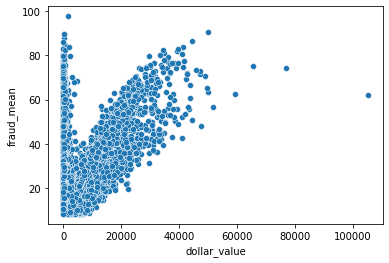

In [20]:
sns.scatterplot(pd_fraud["dollar_value"], pd_fraud["fraud_mean"])

In [21]:
pd_fraud_below_10k = pd_fraud[pd_fraud["dollar_value"] < 10000]

<AxesSubplot:xlabel='dollar_value', ylabel='fraud_mean'>

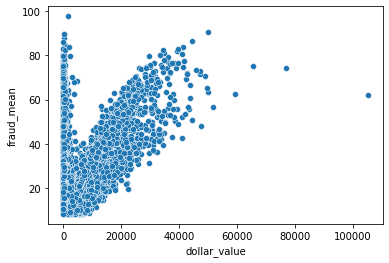

In [22]:
sns.scatterplot(pd_fraud["dollar_value"], pd_fraud["fraud_mean"])

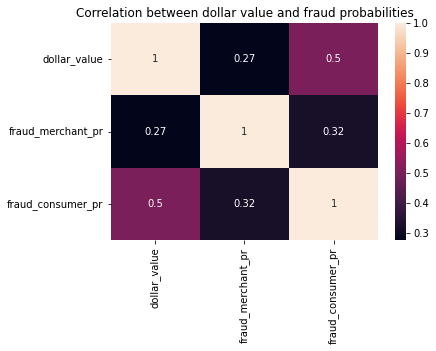

In [23]:
sns.heatmap(pd_fraud[["dollar_value", "fraud_merchant_pr", "fraud_consumer_pr"]].corr(), annot=True)
plt.title('Correlation between dollar value and fraud probabilities')
plt.show()

In [24]:
categories = pd_fraud["categories"].unique().tolist()

In [25]:
for category in categories:
    num_fraud = pd_fraud[pd_fraud["categories"] == category].shape[0]
    num_total = df_trx.where(F.col("categories") == category).count()
    print(f'Proportion of possible fraud in category {category} is {(num_fraud/num_total)*100}%')

Proportion of possible fraud in category florists supplies, nursery stock, and flowers is 0.34333305005523923%


Proportion of possible fraud in category stationery, office supplies and printing and writing paper is 0.8491261863688732%


Proportion of possible fraud in category computers, computer peripheral equipment, and software is 0.4090295275266374%


Proportion of possible fraud in category gift, card, novelty, and souvenir shops is 0.3373773142401417%


Proportion of possible fraud in category digital goods: books, movies, music is 0.30658409206674525%


Proportion of possible fraud in category equipment, tool, furniture, and appliance rent al and leasing is 10.44025978264417%


Proportion of possible fraud in category lawn and garden supply outlets, including nurseries is 1.0321996314688153%


Proportion of possible fraud in category furniture, home furnishings and equipment shops, and manufacturers, except appliances is 0.9473805677359797%


Proportion of possible fraud in category hobby, toy and game shops is 1.3157894736842104%


Proportion of possible fraud in category art dealers and galleries is 14.003624916531527%


Proportion of possible fraud in category motor vehicle supplies and new parts is 1.1972100760292246%


Proportion of possible fraud in category cable, satellite, and other pay television and radio services is 0.3685299017636583%


Proportion of possible fraud in category watch, clock, and jewelry repair shops is 0.3192219715832334%


Proportion of possible fraud in category artist supply and craft shops is 0.6498490508110322%


Proportion of possible fraud in category tent and awning shops is 0.7490738288442086%


Proportion of possible fraud in category shoe shops is 0.38796887524469575%


Proportion of possible fraud in category bicycle shops - sales and service is 1.2267575610476773%


Proportion of possible fraud in category music shops - musical instruments, pianos, and sheet music is 0.6402581647782685%


Proportion of possible fraud in category telecom is 13.279823733081523%


Proportion of possible fraud in category jewelry, watch, clock, and silverware shops is 38.0119366124717%


Proportion of possible fraud in category opticians, optical goods, and eyeglasses is 0.4744559593360654%


Proportion of possible fraud in category health and beauty spas is 0.5050713190008471%


Proportion of possible fraud in category computer programming , data processing, and integrated systems design services is 0.3836716679448439%


Proportion of possible fraud in category books, periodicals, and newspapers is 0.38716227261386155%


Proportion of possible fraud in category antique shops - sales, repairs, and restoration services is 1.2927934057816055%


In [26]:
all_trx = df_trx.join(fraud_data_merchant, on=["merchant_abn", "order_datetime"], how="left").withColumnRenamed("fraud_probability", "fraud_merchant_pr")
all_trx = all_trx.join(fraud_data_consumer, on=["user_id", "order_datetime"], how="left").withColumnRenamed("fraud_probability", "fraud_consumer_pr")
all_trx = all_trx.distinct()

In [27]:
@F.udf(BinaryType())
def fraud_bool(col1, col2):
    if col1 is not None or col2 is not None:
        return True
    else:
        return False

In [111]:
dollar_trx_merchant = fraud_trx.groupby(["merchant_abn", "order_datetime", "fraud_merchant_pr"]).agg(F.sum(F.col("dollar_value")).alias("total_value"), \
    F.count("dollar_value").alias("num_transactions"), F.countDistinct("user_id").alias("unique_customers"))
dollar_pd_merchant = dollar_trx_merchant.toPandas()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/home/aaa/.local/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/aaa/.local/lib/python3.8/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [101]:
dollar_pd_merchant[dollar_pd_merchant["fraud_merchant_pr"].notnull()]

,merchant_abn,order_datetime,fraud_merchant_pr,total_value
74,39649557865,2021-11-26,28.690205,44056.898577
75,90918180829,2021-10-29,34.341900,54961.752053
312,83199298021,2022-02-17,25.779984,58839.709051
404,87084550311,2021-11-26,40.732059,43934.750611
608,31334588839,2021-11-29,35.386211,63637.379637
...,...,...,...,...
37520,15043504837,2021-08-29,59.776489,47381.937091
40993,79100970961,2022-01-02,67.117737,41689.730399
42555,91880575299,2021-04-17,32.994980,105193.885789
43885,14530561097,2021-09-15,80.800545,46001.139019


<AxesSubplot:xlabel='total_value', ylabel='fraud_merchant_pr'>

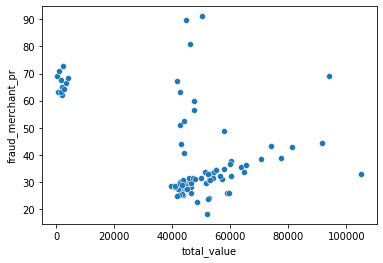

In [104]:
sns.scatterplot(dollar_pd_merchant["total_value"], dollar_pd_merchant["fraud_merchant_pr"])

Current category: opticians, optical goods, and eyeglasses


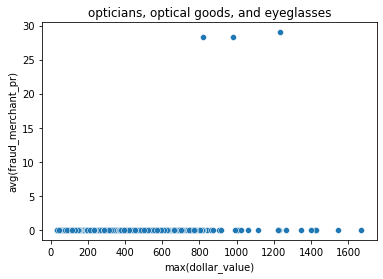

Current category: watch, clock, and jewelry repair shops


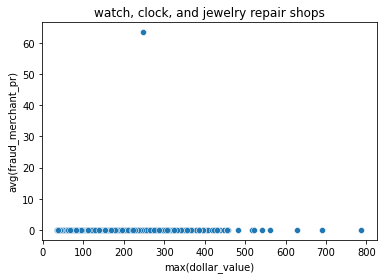

Current category: computer programming , data processing, and integrated systems design services


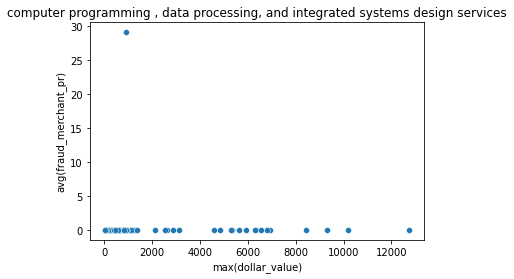

Current category: digital goods: books, movies, music


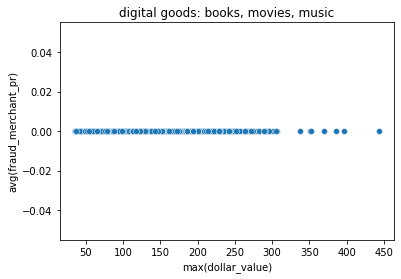

Current category: books, periodicals, and newspapers


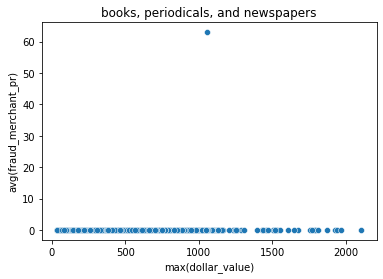

Current category: florists supplies, nursery stock, and flowers


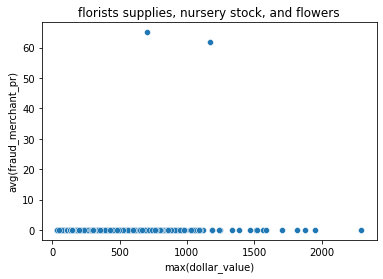

Current category: art dealers and galleries


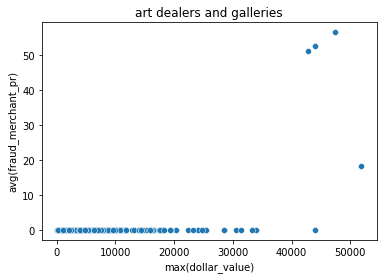

Current category: antique shops - sales, repairs, and restoration services


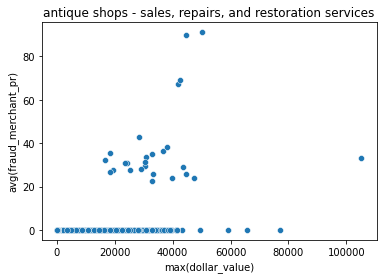

Current category: gift, card, novelty, and souvenir shops


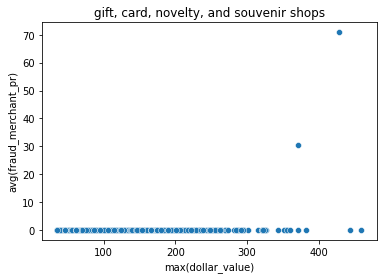

Current category: equipment, tool, furniture, and appliance rent al and leasing


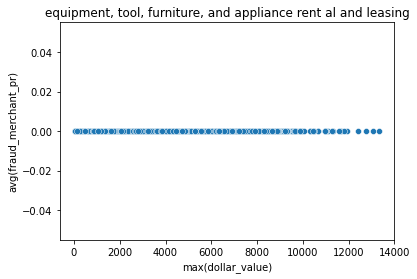

Current category: cable, satellite, and other pay television and radio services


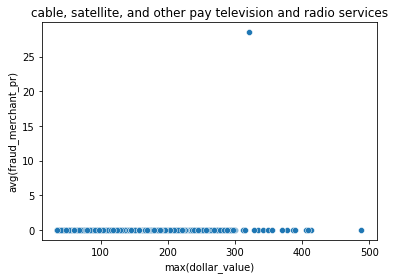

Current category: tent and awning shops


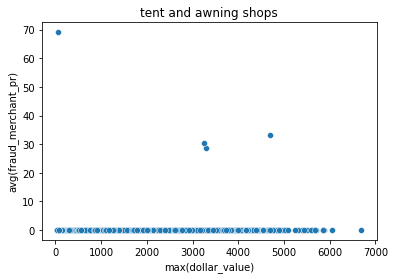

Current category: artist supply and craft shops


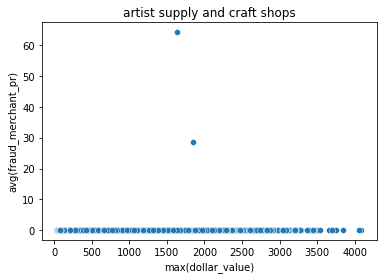

Current category: stationery, office supplies and printing and writing paper


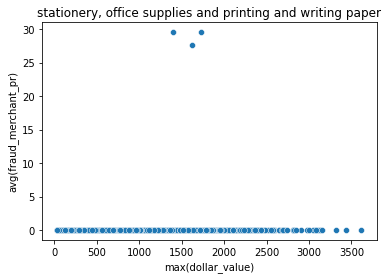

Current category: furniture, home furnishings and equipment shops, and manufacturers, except appliances


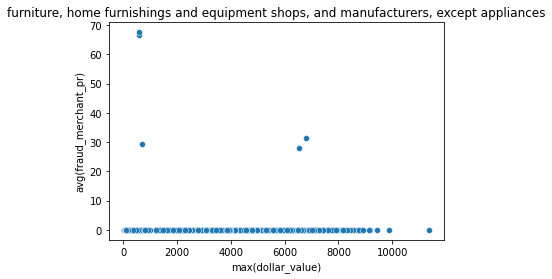

Current category: telecom


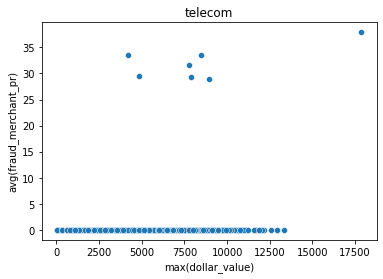

Current category: jewelry, watch, clock, and silverware shops


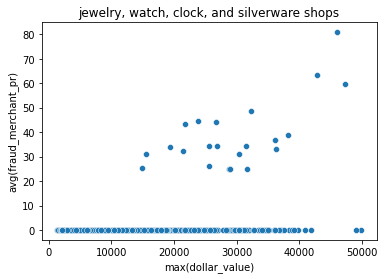

Current category: shoe shops


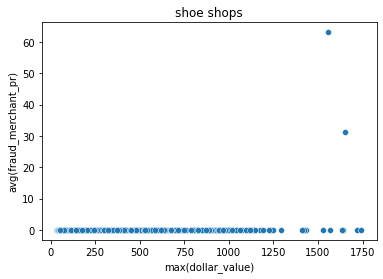

Current category: hobby, toy and game shops


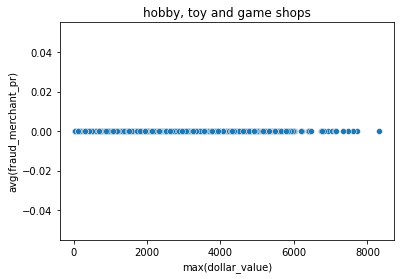

Current category: computers, computer peripheral equipment, and software


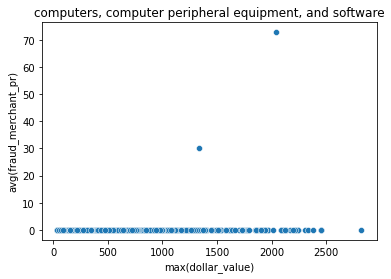

Current category: music shops - musical instruments, pianos, and sheet music


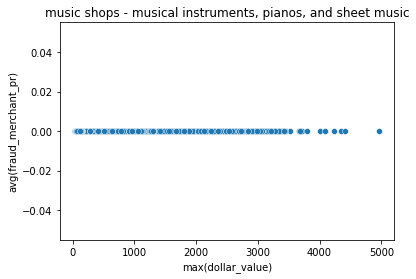

Current category: health and beauty spas


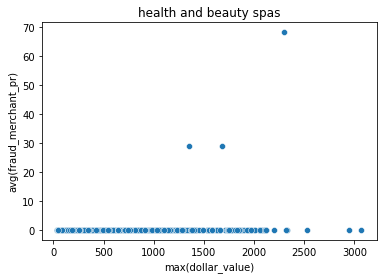

Current category: lawn and garden supply outlets, including nurseries


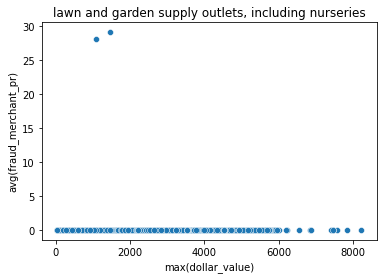

Current category: motor vehicle supplies and new parts


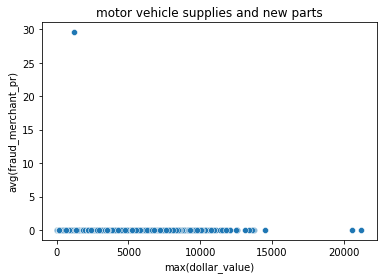

Current category: bicycle shops - sales and service


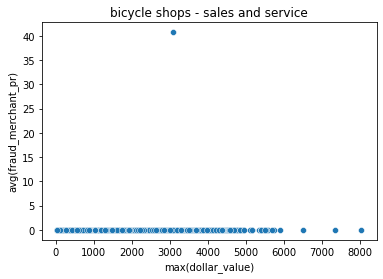

In [52]:
categories = all_trx.select("categories").distinct().collect()
for category in categories:
    category = category["categories"]
    category_trx = all_trx.where(F.col("categories") == category)
    category_trx = category_trx.groupby(["merchant_abn", "order_datetime"]).agg(F.mean(F.col("fraud_merchant_pr")), F.mean(F.col("fraud_consumer_pr")), \
    F.count(F.col("dollar_value")), F.max(F.col("dollar_value")), F.min(F.col("dollar_value")))
    category_trx = category_trx.fillna(0)
    category_trx = category_trx.toPandas()
    print(f"Current category: {category}")
    sns.scatterplot(category_trx["max(dollar_value)"], category_trx["avg(fraud_merchant_pr)"])
    plt.title(category)
    plt.show()

In [82]:
all_consumer = all_trx.groupby(["user_id", "order_datetime", "fraud_consumer_pr"]).agg(F.countDistinct("merchant_abn").alias("unique_merchants"), \
    F.count("dollar_value").alias("num_transactions"), \
        F.sum("dollar_value").alias("total_amount"))

In [84]:
all_consumer = all_consumer.toPandas()

22/09/21 21:07:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 21:07:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 21:07:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 21:07:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 21:07:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 21:07:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 21:07:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 21:07:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 21:07:32 WARN RowBasedKeyValueBatch: Calling spill() on

22/09/21 21:07:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 21:07:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/09/21 21:07:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 21:07:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 21:07:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 21:07:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 21:07:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 21:07:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 21:07:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/09/21 21:07:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 21:07:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/21 21:07:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [85]:
all_consumer = all_consumer.fillna(0)

In [86]:
all_consumer["fraud_consumer_pr"] = all_consumer["fraud_consumer_pr"].astype("float64")

In [91]:
all_consumer["transaction_merchant_ratio"] = all_consumer["unique_merchants"] / all_consumer["num_transactions"]

<AxesSubplot:>

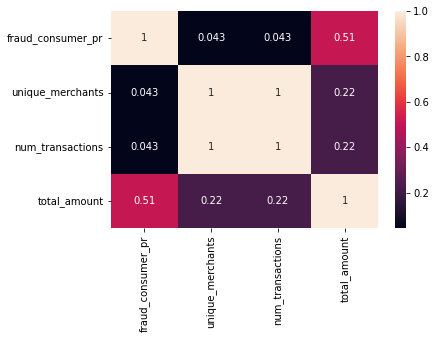

In [93]:
sns.heatmap(all_consumer[["fraud_consumer_pr", "unique_merchants", "num_transactions", "total_amount"]].corr(), annot=True)